# Correlation between CMIP6 and ERA5


This notebooks show the correlation of precipitation between CMIP6 model simulation and observation data from ERA5.

* Open CMIP6 and ERA5
* Data interpolation
* Calculate correlation
* Make correlation animation across 35 years

The following material uses Coupled Model Intercomparison Project (CMIP6) and ERA5 data. 

Please visit the NCI Data Catalogue for more information on the [CMIP6](http://dx.doi.org/10.25914/5b98afc88531e) and [ERA5](http://dx.doi.org/10.25914/5f48874388857) collections.

---

- Authors: NCI Virtual Research Environment Team
- Keywords: CMIP6, ERA5, correlation, animation
- Create Date: 2020-Jul
    
---

This notebook is licenced under the [Creative Commons Attribution 4.0 International license](https://creativecommons.org/licenses/by/4.0/)

### Load in the relevant Python libraries

In [1]:
import cftime
import cartopy.crs as ccrs
from dask.distributed import Client
import glob
from IPython.display import display, HTML
from matplotlib import pyplot as plt, animation
import numpy as np
import os
from PIL import Image
import xarray as xr

%matplotlib inline

This notebook was designed for use on NCI's Virtual Desktop Infrastructure (VDI). We recommend you use Dask when running this notebook. You can create a Dask cluster on the VDI by running:

In [2]:
client = Client()
print(client)

/g/data/dk92/apps/anaconda3/2020.12/envs/NCI-data-analysis_2020.12/lib/python3.7/site-packages/distributed/node.py:244: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33985 instead
  http_address["port"], self.http_server.port


<Client: 'tcp://127.0.0.1:35933' processes=4 threads=8, memory=30.06 GB>


### Open CMIP6 data

Let's take a look at some CMIP6 precipitation data from the [IPSL-CM6A-LR](https://cmc.ipsl.fr/ipsl-climate-models/ipsl-cm6/) climate model.

In [3]:
### location of our CMIP6 example data
file = '/g/data/oi10/replicas/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r1i1p1f1/Amon/pr/gr/v20180803/pr_Amon_IPSL-CM6A-LR_historical_r1i1p1f1_gr_185001-201412.nc'

### open this dataset using xarray
ds_cmip6 = xr.open_dataset(file)

### convert time axis to 360_day calendar -- see https://unidata.github.io/cftime/api.html for more information on using cftime.num2date
units = 'months since 1850-1-15 00:00:00'
time_360_ref = cftime.num2date(np.arange(0, (2014-1850+1)*12), units, '360_day')
ds_cmip6 = ds_cmip6.assign_coords(time=time_360_ref)
ds_cmip6

<xarray.Dataset>
Dimensions:      (axis_nbounds: 2, lat: 143, lon: 144, time: 1980)
Coordinates:
  * lat          (lat) float32 -90.0 -88.73239 -87.46479 ... 88.73239 90.0
  * lon          (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time         (time) object 1850-01-15 00:00:00 ... 2014-12-15 00:00:00
Dimensions without coordinates: axis_nbounds
Data variables:
    time_bounds  (time, axis_nbounds) datetime64[ns] ...
    pr           (time, lat, lon) float32 ...
Attributes:
    Conventions:            CF-1.7 CMIP-6.2
    creation_date:          2018-07-11T07:36:41Z
    tracking_id:            hdl:21.14100/f63dbc41-c629-41a4-8646-c3423a1f1379
    description:            CMIP6 historical
    title:                  IPSL-CM6A-LR model output prepared for CMIP6 / CM...
    activity_id:            CMIP
    contact:                ipsl-cmip6@listes.ipsl.fr
    data_specs_version:     01.00.21
    dr2xml_version:         1.11
    experiment_id:          historical
    experiment:             all-forcing simulation of the recent past
    external_variables:     areacella
    forcing_index:          1
    frequency:              mon
    grid:                   LMDZ grid
    grid_label:             gr
    nominal_resolution:     250 km
    initialization_index:   1
    institution_id:         IPSL
    institution:            Institut Pierre Simon Laplace, Paris 75252, France
    license:                CMIP6 model data produced by IPSL is licensed und...
    mip_era:                CMIP6
    parent_experiment_id:   piControl
    parent_mip_era:         CMIP6
    parent_activity_id:     CMIP
    parent_source_id:       IPSL-CM6A-LR
    parent_time_units:      days since 1850-01-01 00:00:00
    branch_method:          standard
    branch_time_in_parent:  21914.0
    branch_time_in_child:   0.0
    physics_index:          1
    product:                model-output
    realm:                  atmos
    source:                 IPSL-CM6A-LR (2017):  atmos: LMDZ (NPv6, N96; 144...
    source_id:              IPSL-CM6A-LR
    source_type:            AOGCM BGC
    sub_experiment_id:      none
    sub_experiment:         none
    table_id:               Amon
    variable_id:            pr
    EXPID:                  historical
    CMIP6_CV_version:       cv=6.2.3.5-2-g63b123e
    dr2xml_md5sum:          f1e40c1fc5d8281f865f72fbf4e38f9d
    model_version:          6.1.5
    parent_variant_label:   r1i1p1f1
    name:                   /ccc/work/cont003/gencmip6/p86caub/IGCM_OUT/IPSLC...
    further_info_url:       https://furtherinfo.es-doc.org/CMIP6.IPSL.IPSL-CM...
    variant_label:          r1i1p1f1
    realization_index:      1
    history:                Sat Dec  1 12:16:37 2018: ncatted -O -a realizati...
    NCO:                    "4.6.0"

### ERA5 observation data 

Now let's take a look at some ERA5 single level monthly averaged precipitation data found in project rt52:

In [4]:
### location of our ERA5 example data
directory = '/g/data/rt52/era5/single-levels/monthly-averaged/tp/'

### define files we want to read in
era5_files = sorted(list(glob.glob(os.path.join(directory,'*/*.nc'))))
era5_files

### open a multi file dataset using xarray:
ds_tp_mon = xr.open_mfdataset(era5_files,combine='by_coords',parallel=True)

ds_tp_mon

,Array,Chunk
Bytes,2.08 GB,4.15 MB
Shape,"(502, 721, 1440)","(1, 721, 1440)"
Count,1506 Tasks,502 Chunks
Type,float32,numpy.ndarray


In [5]:
### rename ERA5 coordinates so that they are the same as our CMIP6 coordinates
ds_tp_mon = ds_tp_mon.rename({'latitude':'lat'}).rename({'longitude':'lon'}).rename({'tp':'pr'})

In [6]:
### make sure indexes along dimension 'time' are equal
units = 'months since 1979-1-15 00:00:00'
time_360_ref = cftime.num2date(np.arange(0, (2020-1979+1)*12), units, '360_day')
time_360_ref_new = time_360_ref[0:time_360_ref.size-2] ### ensuring time co-ordines are same size (i.e. both end in October 2020)

ds_tp_mon=ds_tp_mon.assign_coords(time=time_360_ref_new)
ds_tp_mon=ds_tp_mon.assign_coords(lon=ds_tp_mon.lon+180)

ds_tp_mon

,Array,Chunk
Bytes,2.08 GB,4.15 MB
Shape,"(502, 721, 1440)","(1, 721, 1440)"
Count,1506 Tasks,502 Chunks
Type,float32,numpy.ndarray


### Data interpolation 

Now we can remap our ERA5 dataset(**ds_tp_mon**) so that it's the same resolution as our CMIP6 dataset (**ds_cmip6**):

In [7]:
new_lon = ds_cmip6.lon
new_lat = ds_cmip6.lat
ds_tp_mon_remap = ds_tp_mon.interp(lat=new_lat, lon=new_lon)
ds_tp_mon_remap

,Array,Chunk
Bytes,41.35 MB,82.37 kB
Shape,"(502, 143, 144)","(1, 143, 144)"
Count,3012 Tasks,502 Chunks
Type,float32,numpy.ndarray


### Calculate correlation

Let's use the numpy [corrcoef](https://numpy.org/doc/stable/reference/generated/numpy.corrcoef.html) function to calculate the correlation between our two example datasets. We can use xarray's [apply_ufunc](https://xarray.pydata.org/en/stable/examples/apply_ufunc_vectorize_1d.html) to apply an unvectorised function to xarray objects:

In [8]:
def get_corrcoef(inarray1, inarray2):
    return np.corrcoef(inarray1, inarray2)[0, 1]

### Let's use the year 2000 as a test case
np.seterr(divide='ignore', invalid='ignore') ### Ignore "invalid value encountered in true_divide" warning messages

cc = xr.apply_ufunc(

    get_corrcoef,    ### The function we defined above

    (ds_cmip6['pr'].sel(time=slice('2000','2000'))), (ds_tp_mon_remap['pr'].sel(time=slice('2000','2000'))),   ###  input our CMIP6 and ERA5 data arrays at year 2000

    input_core_dims=[['time'], ['time']], dask='allowed',

    vectorize=True) ### For more information on numpy.vectorise, see https://numpy.org/doc/stable/reference/generated/numpy.vectorize.html


### Plotting

Let's use cartopy to plot the correlation of Precipitation for CMIP6 vs ERA5

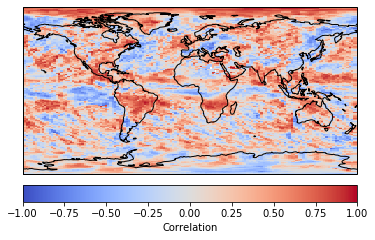

In [9]:
#from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size

### Choose a year to plot
year=2000

fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_title('Correlation of Pr CMIP6 vs ERA5 '+str(year)+'')
ax.coastlines()  ## add in coastlines
colorlabel=np.linspace(-1, 1, 9)
cc.plot(ax=ax, vmin=-1, vmax=1, cmap='coolwarm', add_colorbar=True, add_labels=True, cbar_kwargs={'orientation':'horizontal', 'pad':0.05, 'shrink':1, 'label':'Correlation', 'ticks':colorlabel, 'spacing':'proportional'})

### Make animation

Now we can create a CMIP6 vs ERA5 precipitation correlation animation over our 35 year overlapping period from 1979 to 2014. First let's create a PNG file correlation plot per year: 

In [10]:
fig = plt.figure()
ax = []
np.seterr(divide='ignore', invalid='ignore') ### Ignore "invalid value encountered in true_divide" warning messages

### create output directory if it doesn't exist already
outdir = './output'
if not os.path.exists(outdir):
    os.mkdir(outdir)

for i in range(36):  
    year=1979+i   ### for years 1979-2014
    cc = xr.apply_ufunc(

    get_corrcoef, 

    (ds_cmip6['pr'].sel(time=slice(str(year),str(year)))), (ds_tp_mon_remap['pr'].sel(time=slice(str(year),str(year)))),        # then the input data arrays

    input_core_dims=[['time'], ['time']], dask='allowed',

    vectorize=True

    )
    ax.append([])

    ax[i] = plt.axes(projection=ccrs.PlateCarree())
    ax[i].coastlines()
    cc.plot(ax=ax[i],
        vmin=-1, vmax=1,
        cmap='coolwarm',    # Change the colormap back to 'bwr'
        cbar_kwargs={
            'extend':'neither' # Don't extend the colorbar in either direction. Other possibilities
                               # would be 'both', 'min', or 'max'
        }
    )
    plt.title(f"Correlation of Pr CMIP6 vs ERA5 {year}")
    plt.savefig(f"output/Correlation_of_Pr_CMIP6_vs_ERA5_{year}.png")
    plt.close()

Next we can convert our PNG files into a GIF:

In [11]:
### create GIF from PNG files

img, *imgs = [Image.open(f) for f in sorted(glob.glob('output/Correlation_of_Pr_CMIP6_vs_ERA5_*.png'))]
img.save(fp='output/correlation.gif', format='GIF', append_images=imgs,
         save_all=True, duration=200, loop=0)

### clean up output directory
del_files = glob.glob('output/Correlation_of_Pr_CMIP6_vs_ERA5_*.png')
for file in del_files:
    os.remove(file)

In [12]:
display(HTML("<img src='output/correlation.gif' />"))

### Close the client

Make sure to close your client or stop the kernel.

In [13]:
client.close()

### Summary
This notebook shows correlation maps between CMIP6 and ERA5 data, which demonstrate the areas where model simulations are consistent with observations.

## Reference

https://vimeo.com/112794571